In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import pickle
from pprint import pprint


%matplotlib inline

In [2]:
fs_dropouts = pd.read_csv('data/9th_grade_dropouts.csv', index_col='sid')

In [3]:
fs_dropouts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52932 entries, 2 to 111990
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dropout           52932 non-null  int64  
 1   male              52932 non-null  float64
 2   math_ss           52932 non-null  float64
 3   read_ss           52932 non-null  float64
 4   gifted            52932 non-null  int64  
 5   ever_alternative  52932 non-null  int64  
 6   iep               52932 non-null  int64  
 7   pct_days_absent   52932 non-null  float64
 8   gpa               52932 non-null  float64
 9   frpl              52932 non-null  float64
 10  ell               52932 non-null  int64  
 11  race_num          52932 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 5.2 MB


OK, let's train/test/split our data

In [4]:
X = fs_dropouts.copy()

In [5]:
y = X.pop('dropout')
y

sid
2         0
5         0
12        1
13        0
14        0
         ..
111984    0
111985    0
111986    0
111988    1
111990    0
Name: dropout, Length: 52932, dtype: int64

In [6]:
X

,male,math_ss,read_ss,gifted,ever_alternative,iep,pct_days_absent,gpa,frpl,ell,race_num
sid,,,,,,,,,,,
2,0.0,-1.0,-1.0,0,1,0,10.664031,1.230000,1.0,0,0
5,0.0,18.0,46.0,0,0,0,0.969005,2.822795,1.0,0,0
12,0.0,18.0,35.0,0,1,0,4.746706,0.330000,0.0,0,0
13,0.0,48.0,80.0,0,0,1,6.850071,2.985000,1.0,0,0
14,1.0,18.0,30.0,0,0,0,5.802631,2.118500,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
111984,1.0,34.0,44.0,0,1,1,9.833898,2.079800,1.0,0,1
111985,0.0,23.0,51.0,1,1,0,2.291429,3.443500,0.0,0,0
111986,1.0,4.0,18.0,0,0,1,7.766962,1.695142,1.0,0,0


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [9]:
y_pred = rf.predict(X_test)
rf.score(X_test,y_test)

0.8559823677581864

In [10]:
cm_rf = confusion_matrix(y_test,y_pred)
cm_rf

array([[12242,   611],
       [ 1676,  1351]])

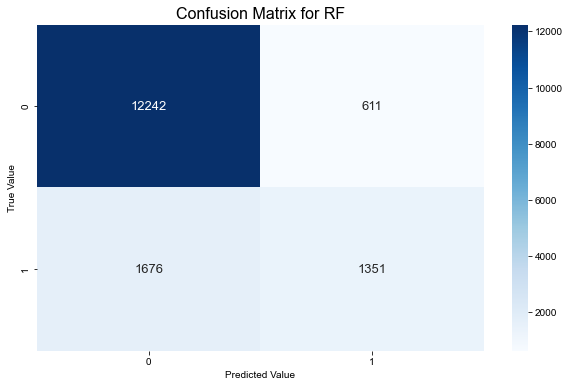

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_rf, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for RF', fontsize = 16)
plt.savefig('confusion-matrix-random-forest.png')

In [12]:
score = classification_report(y_test,y_pred, target_names = ['Not Dropout', 'Dropout'])
print(score)

              precision    recall  f1-score   support

 Not Dropout       0.88      0.95      0.91     12853
     Dropout       0.69      0.45      0.54      3027

    accuracy                           0.86     15880
   macro avg       0.78      0.70      0.73     15880
weighted avg       0.84      0.86      0.84     15880



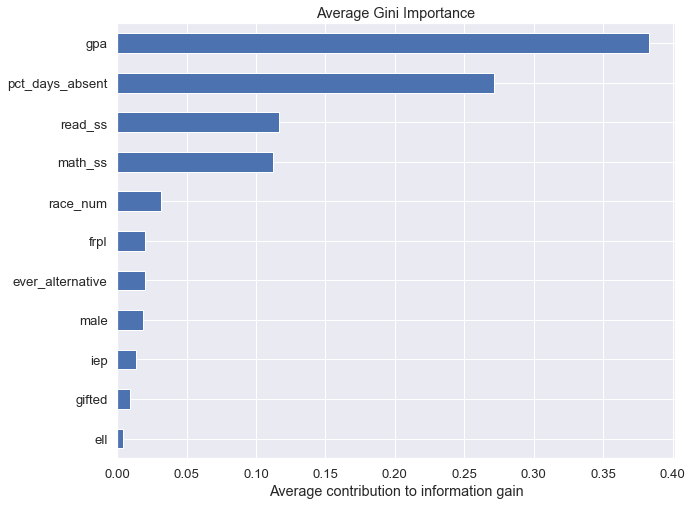

In [13]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

Number of features for 95% importance: 9


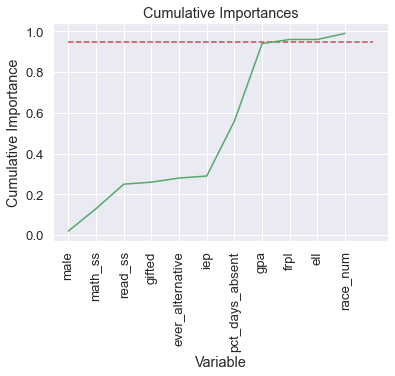

In [14]:
# Get numerical feature importances
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]

# List of features sorted from most to least important
x_values = list(range(len(importances)))
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');


# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

This is not the best...Let's see if we can improve it. I want my dropout precision to be better! 

In [15]:
#Because class is imbalanced, let's try doing some minority class oversampling
os = SMOTE(random_state=0)
X_os, y_os = os.fit_sample(X_train, y_train)
print("length of oversampled data is ",len(X_os))
print("number of negative case in oversampled data",len(y_os == 0))
print("Proportion of no subscription data in oversampled data is ",len(y_os==0)/len(X_os))

length of oversampled data is  60388
number of negative case in oversampled data 60388
Proportion of no subscription data in oversampled data is  1.0


In [16]:
X_os.shape

(60388, 11)

In [17]:
X_train.shape

(37052, 11)

In [18]:
rf.fit(X_os,y_os)
y_pred_os = rf.predict(X_test)
rf.score(X_test,y_test)



0.8290931989924433

In [19]:
cm_rf = confusion_matrix(y_test,y_pred_os)
cm_rf

array([[11405,  1448],
       [ 1266,  1761]])

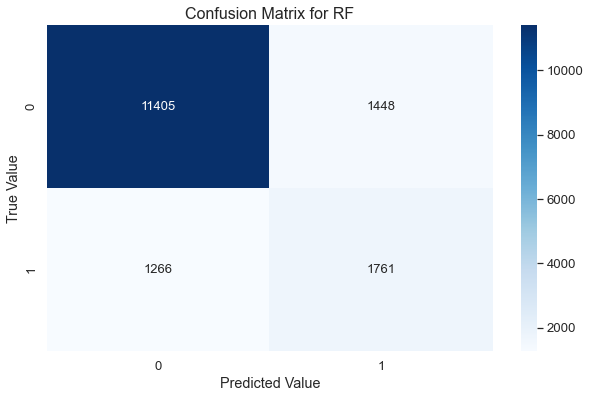

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_rf, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for RF', fontsize = 16)
plt.savefig('confusion-matrix-random-forest-with-SMOTE.png')

In [21]:
os_score = classification_report(y_test,y_pred_os, target_names = ['Not Dropout', 'Dropout'])
print(os_score)

              precision    recall  f1-score   support

 Not Dropout       0.90      0.89      0.89     12853
     Dropout       0.55      0.58      0.56      3027

    accuracy                           0.83     15880
   macro avg       0.72      0.73      0.73     15880
weighted avg       0.83      0.83      0.83     15880



Let's do some more feature engineering...Let's drop the last three cols

In [22]:
lowest_features = feat_scores.index[:3]

In [23]:
X_new = X.drop(lowest_features, axis=1)

In [24]:
X

,male,math_ss,read_ss,gifted,ever_alternative,iep,pct_days_absent,gpa,frpl,ell,race_num
sid,,,,,,,,,,,
2,0.0,-1.0,-1.0,0,1,0,10.664031,1.230000,1.0,0,0
5,0.0,18.0,46.0,0,0,0,0.969005,2.822795,1.0,0,0
12,0.0,18.0,35.0,0,1,0,4.746706,0.330000,0.0,0,0
13,0.0,48.0,80.0,0,0,1,6.850071,2.985000,1.0,0,0
14,1.0,18.0,30.0,0,0,0,5.802631,2.118500,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
111984,1.0,34.0,44.0,0,1,1,9.833898,2.079800,1.0,0,1
111985,0.0,23.0,51.0,1,1,0,2.291429,3.443500,0.0,0,0
111986,1.0,4.0,18.0,0,0,1,7.766962,1.695142,1.0,0,0


In [25]:
X_new

,male,math_ss,read_ss,ever_alternative,pct_days_absent,gpa,frpl,race_num
sid,,,,,,,,
2,0.0,-1.0,-1.0,1,10.664031,1.230000,1.0,0
5,0.0,18.0,46.0,0,0.969005,2.822795,1.0,0
12,0.0,18.0,35.0,1,4.746706,0.330000,0.0,0
13,0.0,48.0,80.0,0,6.850071,2.985000,1.0,0
14,1.0,18.0,30.0,0,5.802631,2.118500,1.0,0
...,...,...,...,...,...,...,...,...
111984,1.0,34.0,44.0,1,9.833898,2.079800,1.0,1
111985,0.0,23.0,51.0,1,2.291429,3.443500,0.0,0
111986,1.0,4.0,18.0,0,7.766962,1.695142,1.0,0


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=0)

In [27]:
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [28]:
y_pred = rf.predict(X_test)
rf.score(X_test,y_test)

0.8534005037783375

In [29]:
cm_rf = confusion_matrix(y_test,y_pred)
cm_rf

array([[12214,   639],
       [ 1689,  1338]])

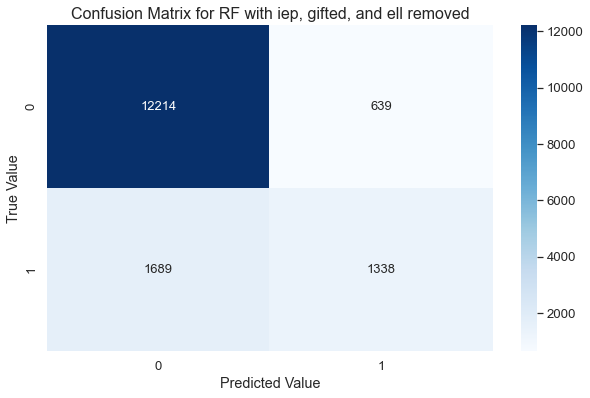

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_rf, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for RF with iep, gifted, and ell removed', fontsize = 16)
plt.savefig('confusion-matrix-random-forest-removed-features.png')

In [31]:
new_score = classification_report(y_test,y_pred, target_names = ['Not Dropout', 'Dropout'])
print(new_score)

              precision    recall  f1-score   support

 Not Dropout       0.88      0.95      0.91     12853
     Dropout       0.68      0.44      0.53      3027

    accuracy                           0.85     15880
   macro avg       0.78      0.70      0.72     15880
weighted avg       0.84      0.85      0.84     15880



In [32]:
X

,male,math_ss,read_ss,gifted,ever_alternative,iep,pct_days_absent,gpa,frpl,ell,race_num
sid,,,,,,,,,,,
2,0.0,-1.0,-1.0,0,1,0,10.664031,1.230000,1.0,0,0
5,0.0,18.0,46.0,0,0,0,0.969005,2.822795,1.0,0,0
12,0.0,18.0,35.0,0,1,0,4.746706,0.330000,0.0,0,0
13,0.0,48.0,80.0,0,0,1,6.850071,2.985000,1.0,0,0
14,1.0,18.0,30.0,0,0,0,5.802631,2.118500,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
111984,1.0,34.0,44.0,0,1,1,9.833898,2.079800,1.0,0,1
111985,0.0,23.0,51.0,1,1,0,2.291429,3.443500,0.0,0,0
111986,1.0,4.0,18.0,0,0,1,7.766962,1.695142,1.0,0,0


In [33]:
from pprint import pprint# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [34]:
X_5 = X[['gpa', 'pct_days_absent']]
X_5

,gpa,pct_days_absent
sid,,
2,1.230000,10.664031
5,2.822795,0.969005
12,0.330000,4.746706
13,2.985000,6.850071
14,2.118500,5.802631
...,...,...
111984,2.079800,9.833898
111985,3.443500,2.291429
111986,1.695142,7.766962


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_5, y, test_size=0.3, random_state=0)
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


In [36]:
rf.score(X_test,y_test)


0.8398614609571788

In [37]:
cm_rf = confusion_matrix(y_test,y_pred)
cm_rf


array([[12114,   739],
       [ 1804,  1223]])

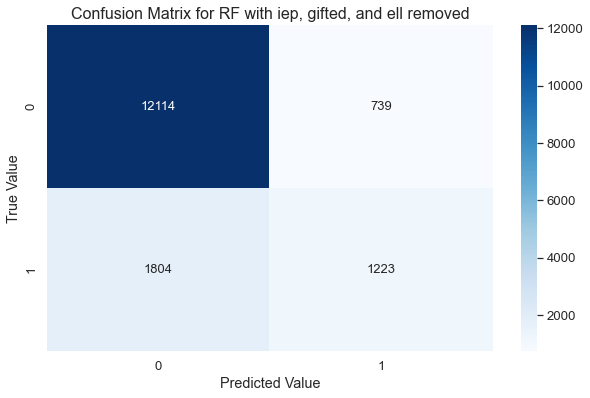

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_rf, annot=True, fmt = "g",cmap = "Blues",annot_kws={"size": 13})
sns.set(font_scale=1.2) # for label size
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix for RF with iep, gifted, and ell removed', fontsize = 16)
plt.savefig('confusion-matrix-random-forest-5-features.png')

In [39]:
new_score = classification_report(y_test,y_pred, target_names = ['Not Dropout', 'Dropout'])
print(new_score)

              precision    recall  f1-score   support

 Not Dropout       0.87      0.94      0.91     12853
     Dropout       0.62      0.40      0.49      3027

    accuracy                           0.84     15880
   macro avg       0.75      0.67      0.70     15880
weighted avg       0.82      0.84      0.83     15880



In [40]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# First create the base model to tune
rf = RandomForestClassifier(n_estimators = 500)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 60.3min


In [ ]:
rf.fit(X_train, y_train)

threshold = 0.4

predicted = rf.predict_proba(X_test)
predicted[:,0] = (predicted[:,0] < threshold).astype('int')
predicted[:,1] = (predicted[:,1] >= threshold).astype('int')


accuracy = accuracy_score(y_test, predicted)
print(round(accuracy,4,)*100, "%")